<a href="https://colab.research.google.com/github/shreyamanapure/nuclei_identifier/blob/main/partB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

  Using cached PyYAML-5.1.tar.gz (274 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
fatal: destination path 'detectron2' already exists and is not an empty directory.


In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

from matplotlib import pyplot as plt

In [ ]:

from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/drive/MyDrive/Nuclei_data/COCO_output/train/coco_annotations.json", "/content/drive/MyDrive/Nuclei_data/COCO_output/train")
register_coco_instances("my_dataset_val", {}, "/content/drive/MyDrive/Nuclei_data/COCO_output/val/coco_annotations.json", "/content/drive/MyDrive/Nuclei_data/COCO_output/val")


In [ ]:
train_metadata = MetadataCatalog.get("my_dataset_train")
train_dataset_dicts = DatasetCatalog.get("my_dataset_train")
val_metadata = MetadataCatalog.get("my_dataset_val")
val_dataset_dicts = DatasetCatalog.get("my_dataset_val")

[12/13 16:28:38 d2.data.datasets.coco]: Loaded 532 images in COCO format from /content/drive/MyDrive/Nuclei_data/COCO_output/train/coco_annotations.json
[12/13 16:28:39 d2.data.datasets.coco]: Loaded 133 images in COCO format from /content/drive/MyDrive/Nuclei_data/COCO_output/val/coco_annotations.json


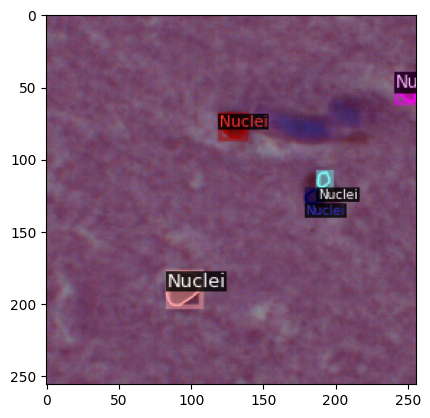

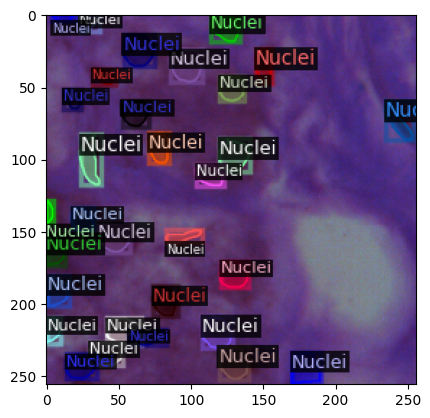

In [ ]:
for d in random.sample(train_dataset_dicts, 2):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()

In [ ]:

from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.OUTPUT_DIR = "/content/drive/MyDrive/Nuclei_data/models/Detectron2_Models"
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1500    # 1000 iterations for demo purposes
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # Default is 512, using 256 for this dataset.
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # We have 1 classes. (Nuclei)
# NOTE: this config means the number of classes, without the background. Do not use num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) #Create an instance of of DefaultTrainer with the given congiguration
trainer.resume_or_load(resume=False) #Load a pretrained model if available (resume training) or start training from scratch if no pretrained model is available



[12/13 16:28:43 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


In [ ]:
trainer.train()

[12/13 16:28:44 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[12/13 16:28:56 d2.utils.events]:  eta: 0:12:49  iter: 19  total_loss: 5.908  loss_cls: 0.6704  loss_box_reg: 0.4978  loss_mask: 0.6931  loss_rpn_cls: 3.704  loss_rpn_loc: 0.2793    time: 0.5261  last_time: 0.6915  data_time: 0.0340  last_data_time: 0.0260   lr: 4.9953e-06  max_mem: 1906M
[12/13 16:29:12 d2.utils.events]:  eta: 0:10:19  iter: 39  total_loss: 3.339  loss_cls: 0.6275  loss_box_reg: 0.6288  loss_mask: 0.6878  loss_rpn_cls: 1.336  loss_rpn_loc: 0.1908    time: 0.4854  last_time: 0.3902  data_time: 0.0143  last_data_time: 0.0266   lr: 9.9902e-06  max_mem: 1906M
[12/13 16:29:20 d2.utils.events]:  eta: 0:09:44  iter: 59  total_loss: 2.751  loss_cls: 0.5843  loss_box_reg: 0.6933  loss_mask: 0.6777  loss_rpn_cls: 0.5964  loss_rpn_loc: 0.2478    time: 0.4489  last_time: 0.3966  data_time: 0.0098  last_data_time: 0.0063   lr: 1.4985e-05  max_mem: 2290M
[12/13 16:29:27 d2.utils.events]:  eta: 0:09:27  iter: 79  total_loss: 2.535  loss_cls: 0.5568  loss_box_reg: 0.6942  loss_mask: 

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join("/content/drive/MyDrive/Nuclei_data/models/Detectron2_Models/model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2   # set a custom threshold
predictor = DefaultPredictor(cfg)

[12/13 16:59:55 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/Nuclei_data/models/Detectron2_Models/model_final.pth ...


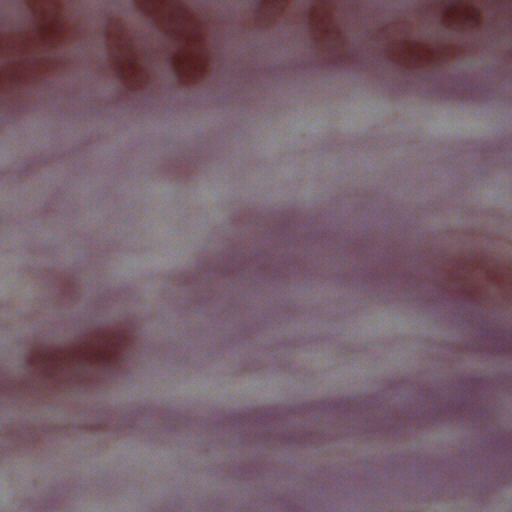

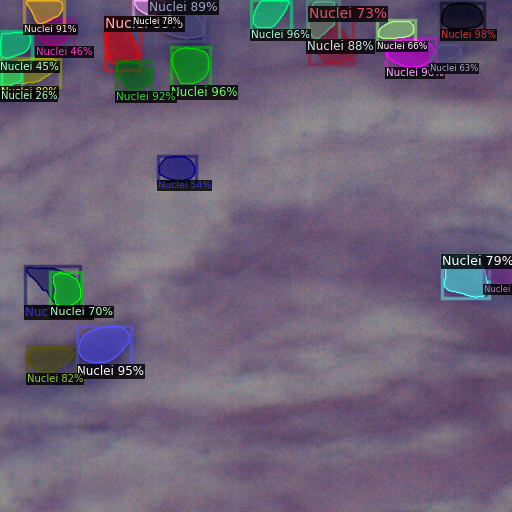

In [ ]:
new_im = cv2.imread("/content/drive/MyDrive/Nuclei_data/COCO_output/val/human_bladder_06.png")
outputs  = predictor(new_im)

# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

cv2_imshow(new_im[:, :, ::-1])
cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_test", {}, "/content/drive/MyDrive/Nuclei_data/COCO_output/val/coco_annotations.json", "/content/drive/MyDrive/Nuclei_data/COCO_output/val")
test_metadata = MetadataCatalog.get("my_dataset_test")
test_dataset_dicts = DatasetCatalog.get("my_dataset_test")

[12/13 17:00:41 d2.data.datasets.coco]: Loaded 133 images in COCO format from /content/drive/MyDrive/Nuclei_data/COCO_output/val/coco_annotations.json


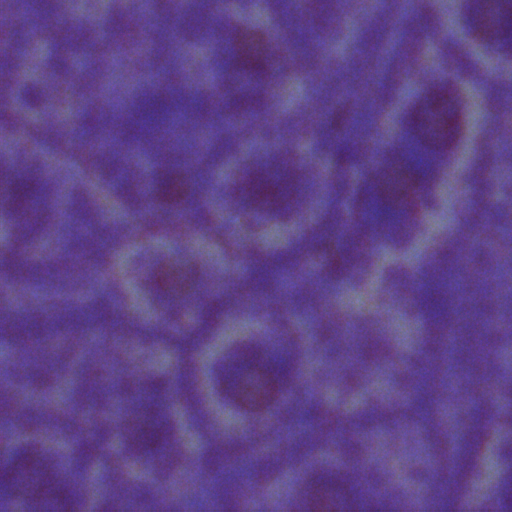

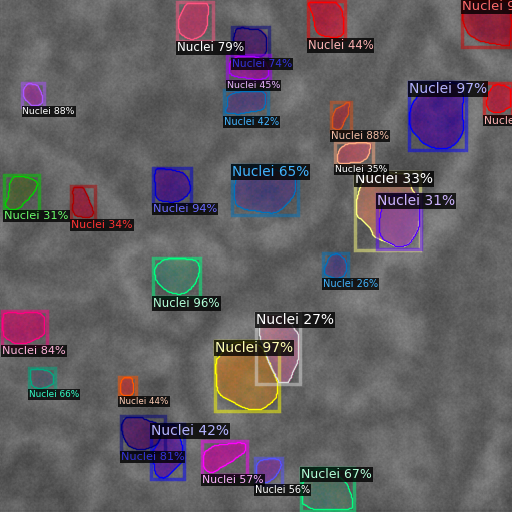

In [ ]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(test_dataset_dicts, 1):    #select number of images for display
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=test_metadata,
                   scale=1,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(im[:, :, ::-1])
    cv2_imshow(out.get_image()[:, :, ::-1])

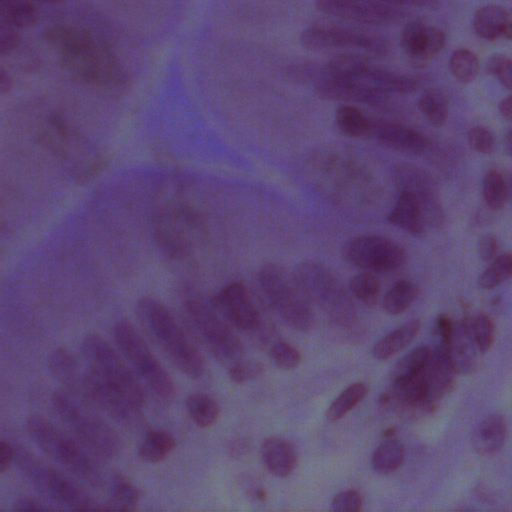

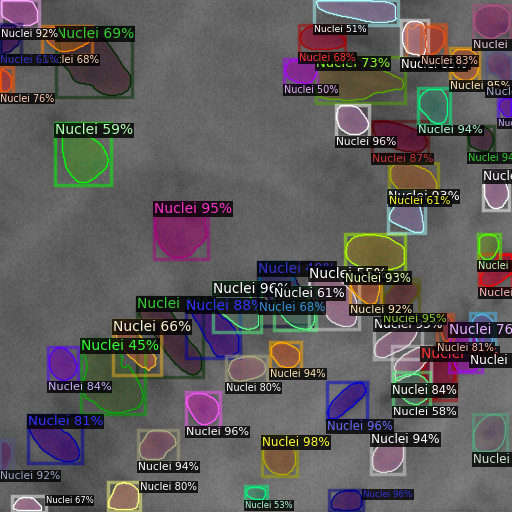

In [ ]:
for d in random.sample(test_dataset_dicts, 1):    #select number of images for display
    im = cv2.imread(d["file_name"])
    outputs2 = predictor(im)

    # Perform prediction on the tile using your trained model
    outputs2 = predictor(im)

# Get the confidence scores
    scores = outputs2["instances"].scores

# Define your custom threshold
    threshold = 0.4

# Filter instances based on confidence threshold
    filtered_indices = [i for i, score in enumerate(scores) if score > threshold]

# Update the instances in the outputs
    outputs2["instances"] = outputs2["instances"][filtered_indices]

    v = Visualizer(im[:, :, ::-1],
                   metadata=test_metadata,
                   scale=1,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs2["instances"].to("cpu"))
    cv2_imshow(im[:, :, ::-1])
    cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("my_dataset_test", output_dir="./output")
test_loader = build_detection_test_loader(cfg, "my_dataset_test")
print(inference_on_dataset(predictor.model, test_loader, evaluator))

[12/13 17:03:22 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
[12/13 17:03:22 d2.data.datasets.coco]: Loaded 133 images in COCO format from /content/drive/MyDrive/Nuclei_data/COCO_output/val/coco_annotations.json
[12/13 17:03:22 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   Nuclei   | 6567         |
|            |              |
[12/13 17:03:22 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/13 17:03:22 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[12/13 17:03:22 d2.data.common]: Serializing 133 elements to byte tensors and concatenating them all ...
[12/13 17:03:23 d2.data.common]: Serialized dataset takes 1.68 MiB
[12/13 17:03:23 d2.evaluation.evaluator]: Start inference on 133 

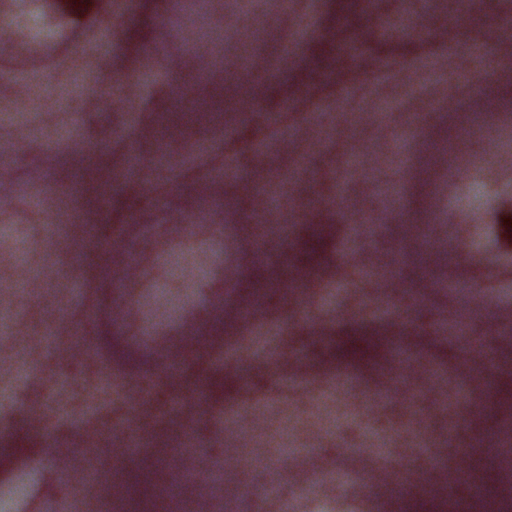

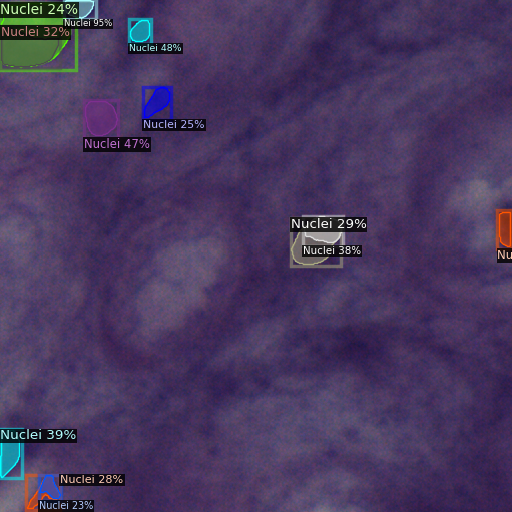

In [ ]:
new_im = cv2.imread("/content/drive/MyDrive/Nuclei_data/COCO_output/val/human_epiglottis_5.png")
outputs  = predictor(new_im)

# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

cv2_imshow(new_im[:, :, ::-1])
cv2_imshow(out.get_image()[:, :, ::-1])